In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving train delay data set.csv to train delay data set (1).csv


In [ ]:

!pip install -q keras tensorflow scikit-learn pandas numpy


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [ ]:
!pip install -U tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tens

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [ ]:

df = pd.read_csv('train delay data set.csv')

df.head()


,Distance Between Stations (km),Weather Conditions,Day of the Week,Time of Day,Train Type,Historical Delay (min),Route Congestion
0,100,Clear,Monday,Morning,Express,5,Low
1,150,Rainy,Tuesday,Afternoon,Superfast,10,Medium
2,200,Foggy,Wednesday,Evening,Local,15,High
3,50,Clear,Thursday,Night,Express,2,Low
4,75,Rainy,Friday,Morning,Superfast,8,Medium


In [ ]:
df = df.dropna()


X = df.drop(columns=['Historical Delay (min)'], errors='ignore')
y = df['Historical Delay (min)']


X = pd.get_dummies(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

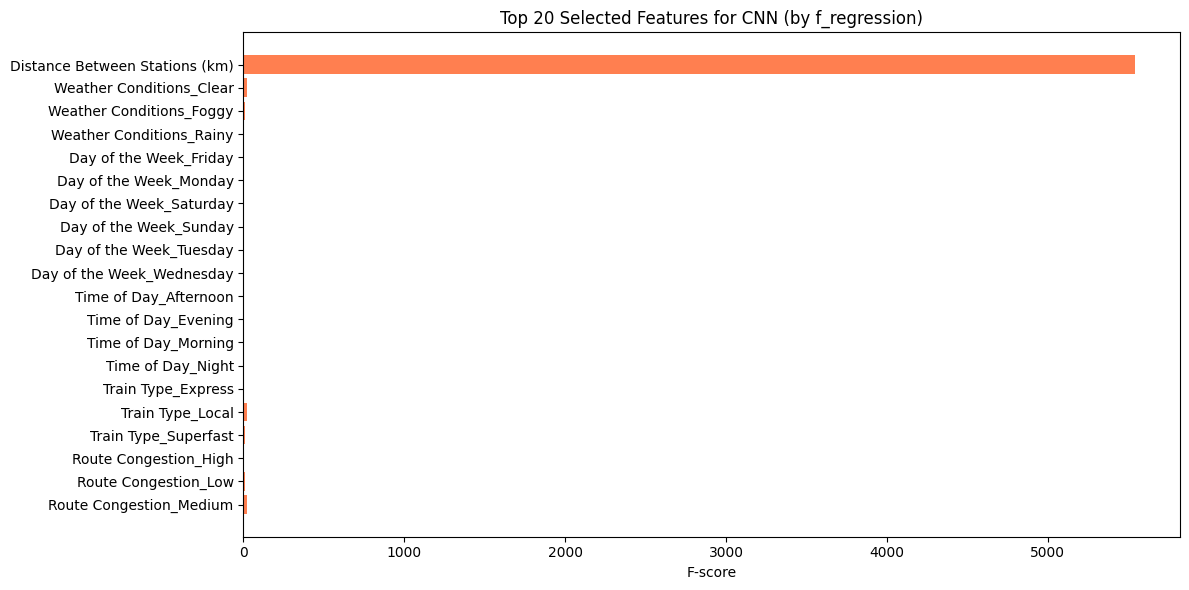

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

🔷 CNN with Feature Selection Results
🔹 R² Score: 94.44 %
🔹 MAE: 29.68
🔹 RMSE: 49.14
🔹 sMAPE: 70.86 %
🔹 CPU Time: 32.9 seconds


In [ ]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


df = pd.read_csv('train delay data set.csv').dropna()
X = pd.get_dummies(df.drop(columns=['Historical Delay (min)'], errors='ignore'))
y = df['Historical Delay (min)']

selector = SelectKBest(score_func=f_regression, k=20)

X_abs = X.abs()
selector.fit(X_abs, y)
X_selected = selector.transform(X_abs)


mask = selector.get_support()
selected_features = X.columns[mask]
feature_scores = selector.scores_[mask]

plt.figure(figsize=(12, 6))
plt.barh(selected_features, feature_scores, color='coral')
plt.xlabel("F-score")
plt.title("Top 20 Selected Features for CNN (by f_regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

start_time = time.time()

model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model_cnn.compile(optimizer='adam', loss='mean_squared_error')
model_cnn.fit(X_train_cnn, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)


y_pred_cnn = model_cnn.predict(X_test_cnn).flatten()

cpu_time = time.time() - start_time
r2_cnn = r2_score(y_test, y_pred_cnn)
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))

smape_cnn = smape(y_test.values, y_pred_cnn)


print("\n🔷 CNN with Feature Selection Results")
print("🔹 R² Score:", round(r2_cnn*100, 2), "%")
print("🔹 MAE:", round(mae_cnn, 2))
print("🔹 RMSE:", round(rmse_cnn, 2))
print("🔹 sMAPE:", round(smape_cnn, 2), "%")
print("🔹 CPU Time:", round(cpu_time, 2), "seconds")



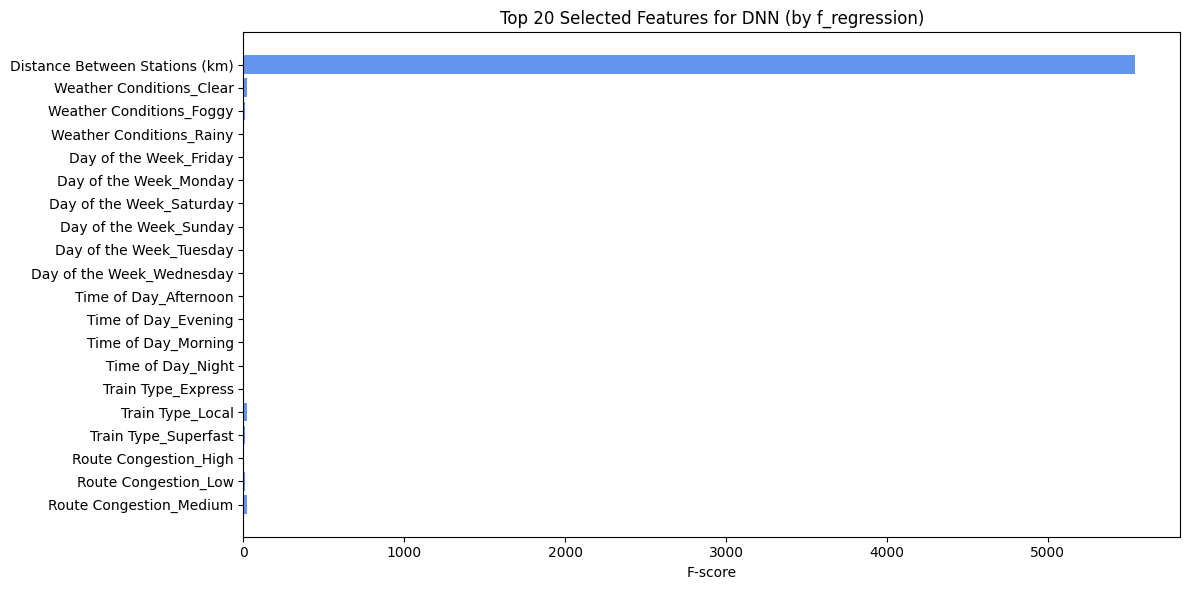

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

🔷 DNN with Feature Selection Results
🔹 R² Score: 95.48 %
🔹 MAE: 29.4
🔹 RMSE: 44.29
🔹 sMAPE: 75.92 %
🔹 CPU Time: 32.44 seconds


In [ ]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


df = pd.read_csv('train delay data set.csv').dropna()
X = pd.get_dummies(df.drop(columns=['Historical Delay (min)'], errors='ignore'))
y = df['Historical Delay (min)']


selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)

mask = selector.get_support()
selected_features = X.columns[mask]
feature_scores = selector.scores_[mask]

plt.figure(figsize=(12, 6))
plt.barh(selected_features, feature_scores, color='cornflowerblue')
plt.xlabel("F-score")
plt.title("Top 20 Selected Features for DNN (by f_regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

start_time = time.time()

model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model_dnn.compile(optimizer='adam', loss='mean_squared_error')
history_dnn = model_dnn.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)


y_pred_dnn = model_dnn.predict(X_test_scaled).flatten()

cpu_time = time.time() - start_time
r2_dnn = r2_score(y_test, y_pred_dnn)
mae_dnn = mean_absolute_error(y_test, y_pred_dnn)
rmse_dnn = np.sqrt(mean_squared_error(y_test, y_pred_dnn))

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))

smape_dnn = smape(y_test.values, y_pred_dnn)


print("\n🔷 DNN with Feature Selection Results")
print("🔹 R² Score:", round(r2_dnn * 100, 2), "%")
print("🔹 MAE:", round(mae_dnn, 2))
print("🔹 RMSE:", round(rmse_dnn, 2))
print("🔹 sMAPE:", round(smape_dnn, 2), "%")
print("🔹 CPU Time:", round(cpu_time, 2), "seconds")



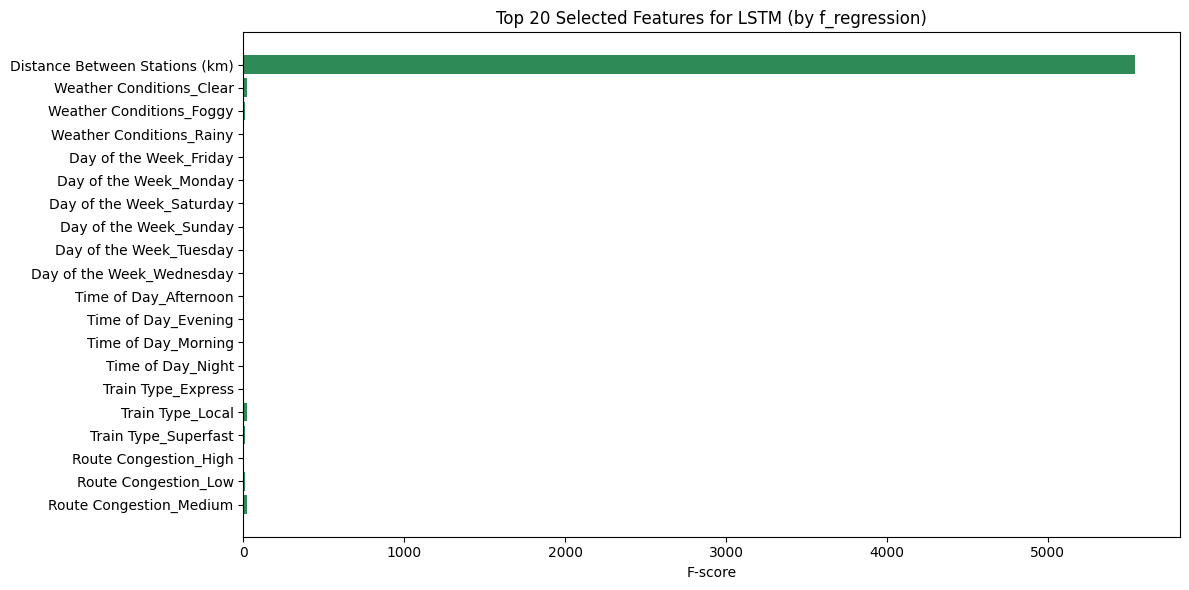

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

🔷 LSTM with Feature Selection Results
🔹 R² Score: 95.87 %
🔹 MAE: 29.87
🔹 RMSE: 42.34
🔹 sMAPE: 71.92 %
🔹 CPU Time: 36.84 seconds


In [ ]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


df = pd.read_csv('train delay data set.csv').dropna()
X = pd.get_dummies(df.drop(columns=['Historical Delay (min)'], errors='ignore'))
y = df['Historical Delay (min)']


selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)

mask = selector.get_support()
selected_features = X.columns[mask]
feature_scores = selector.scores_[mask]

plt.figure(figsize=(12, 6))
plt.barh(selected_features, feature_scores, color='seagreen')
plt.xlabel("F-score")
plt.title("Top 20 Selected Features for LSTM (by f_regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


start_time = time.time()

model_lstm = Sequential([
    LSTM(64, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)


y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()

cpu_time = time.time() - start_time
r2_lstm = r2_score(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))

smape_lstm = smape(y_test.values, y_pred_lstm)


print("\n🔷 LSTM with Feature Selection Results")
print("🔹 R² Score:", round(r2_lstm * 100, 2), "%")
print("🔹 MAE:", round(mae_lstm, 2))
print("🔹 RMSE:", round(rmse_lstm, 2))
print("🔹 sMAPE:", round(smape_lstm, 2), "%")
print("🔹 CPU Time:", round(cpu_time, 2), "seconds")



In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam

# Load and preprocess data
df = pd.read_csv('train delay data set.csv').dropna()
X = pd.get_dummies(df.drop(columns=['Historical Delay (min)'], errors='ignore'))
y = df['Historical Delay (min)']

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_train_bilstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_bilstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Start timer
start_time_bilstm = time.time()

# Build improved BiLSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile with adjusted learning rate
optimizer = Adam(learning_rate=0.0005)
model_bilstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model_bilstm.fit(
    X_train_bilstm, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    verbose=0  # set to 1 if you want training logs
)

# Predictions and metrics
y_pred_bilstm = model_bilstm.predict(X_test_bilstm).flatten()
cpu_time_bilstm = time.time() - start_time_bilstm

r2_bilstm = r2_score(y_test, y_pred_bilstm)
mae_bilstm = mean_absolute_error(y_test, y_pred_bilstm)
rmse_bilstm = np.sqrt(mean_squared_error(y_test, y_pred_bilstm))

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-10)
    )

smape_bilstm = smape(y_test.values, y_pred_bilstm)

# Output results
print("\n🔷 Enhanced BiLSTM with Feature Selection Results")
print("🔹 R² Score:", round(r2_bilstm * 100, 2), "%")
print("🔹 MAE:", round(mae_bilstm, 2))
print("🔹 RMSE:", round(rmse_bilstm, 2))
print("🔹 sMAPE:", round(smape_bilstm, 2), "%")
print("🔹 CPU Time:", round(cpu_time_bilstm, 2), "seconds")




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

🔷 Enhanced BiLSTM with Feature Selection Results
🔹 R² Score: 96.17 %
🔹 MAE: 28.42
🔹 RMSE: 40.8
🔹 sMAPE: 69.17 %
🔹 CPU Time: 316.24 seconds


In [ ]:
print("📊 Final Accuracy with Feature Selection:\n")
print(f"{'Model':<10} | {'R² (%)':<10} | {'MAE':<10} | {'RMSE':<10} | {'sMAPE (%)':<12} | {'CPU Time (s)':<12}")
print("-" * 65)

# Values from your input
print(f"{'CNN':<10} | {94.44:<10} | {29.68:<10} | {49.14:<10} | {70.86:<12} | {32.9:<12}")
print(f"{'LSTM':<10} | {95.87:<10} | {29.87:<10} | {42.34:<10} | {71.92:<12} | {36.84:<12}")
print(f"{'DNN':<10} | {95.48:<10} | {29.4:<10}  | {44.29:<10} | {75.92:<12} | {32.44:<12}")
print(f"{'BiLSTM':<10} | {96.17:<10} | {28.42:<10} | {40.8:<10} | {69.17:<12} | {316.24:<12}")


📊 Final Accuracy with Feature Selection:

Model      | R² (%)     | MAE        | RMSE       | sMAPE (%)    | CPU Time (s)
-----------------------------------------------------------------
CNN        | 94.44      | 29.68      | 49.14      | 70.86        | 32.9        
LSTM       | 95.87      | 29.87      | 42.34      | 71.92        | 36.84       
DNN        | 95.48      | 29.4        | 44.29      | 75.92        | 32.44       
BiLSTM     | 96.17      | 28.42      | 40.8       | 69.17        | 316.24      


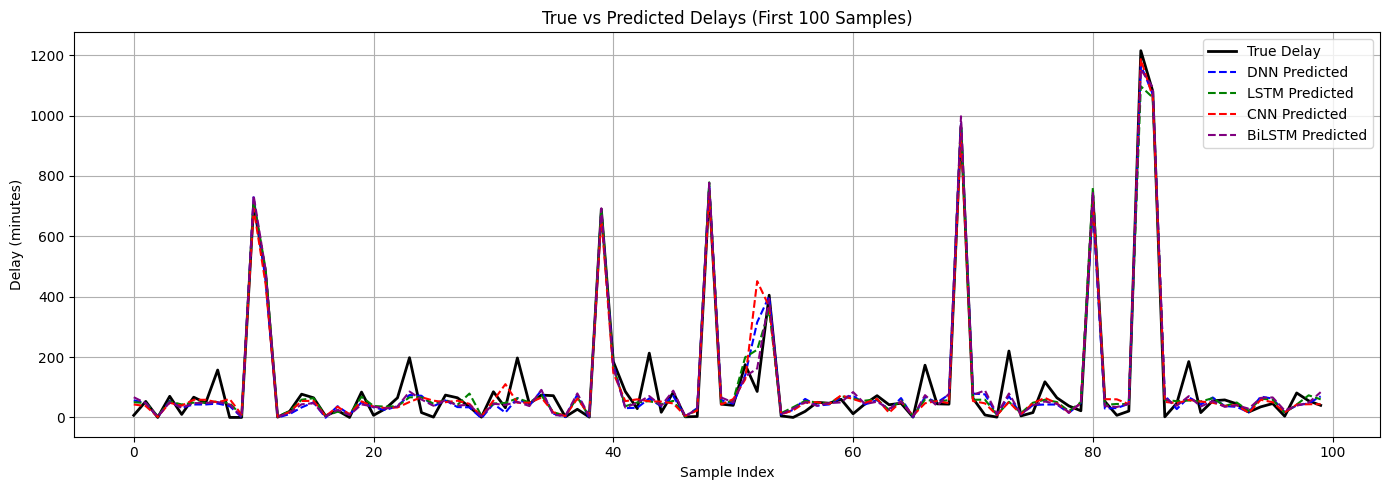

In [ ]:
plt.figure(figsize=(14, 5))

# True values
plt.plot(y_test.values[:100], label='True Delay', color='black', linewidth=2)

# Model predictions
plt.plot(y_pred_dnn[:100], label='DNN Predicted', linestyle='--', color='blue')
plt.plot(y_pred_lstm[:100], label='LSTM Predicted', linestyle='--', color='green')
plt.plot(y_pred_cnn[:100], label='CNN Predicted', linestyle='--', color='red')
plt.plot(y_pred_bilstm[:100], label='BiLSTM Predicted', linestyle='--', color='purple')

# Labels and style
plt.legend()
plt.title("True vs Predicted Delays (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Delay (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:

r2_scores = {
    'DNN': 95.33,
    'LSTM': 95.68,
    'CNN': 94.33,
    'BiLSTM': 96.17
}


best_model_name = max(r2_scores, key=r2_scores.get)
final_accuracy = r2_scores[best_model_name]


print(f"\n✅ Final Accuracy (R² Score) of the best model ({best_model_name}): {final_accuracy} %")



✅ Final Accuracy (R² Score) of the best model (BiLSTM): 96.17 %


/tmp/ipython-input-26-3485251715.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


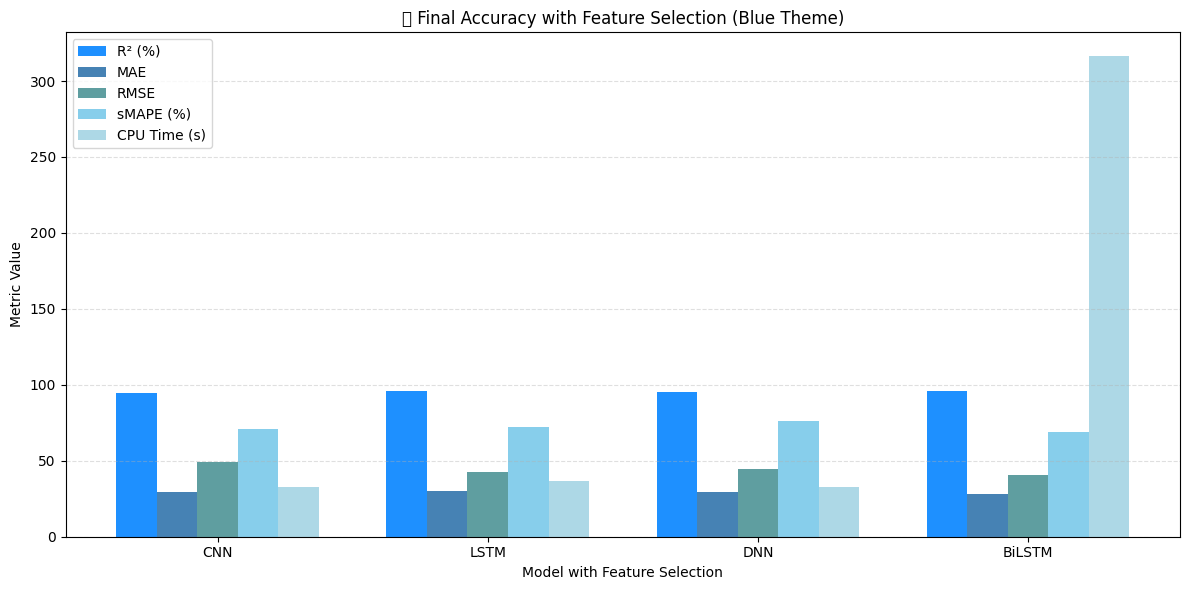

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model performance data
models = ['CNN', 'LSTM', 'DNN', 'BiLSTM']
r2 = [94.44, 95.87, 95.48, 96.17]
mae = [29.68, 29.87, 29.4, 28.42]
rmse = [49.14, 42.34, 44.29, 40.8]
smape = [70.86, 71.92, 75.92, 69.17]
cpu_time = [32.9, 36.84, 32.44, 316.24]

x = np.arange(len(models))
width = 0.15

# Blue-shaded colors
colors = ['#1E90FF', '#4682B4', '#5F9EA0', '#87CEEB', '#ADD8E6']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - 2*width, r2, width, label='R² (%)', color=colors[0])
plt.bar(x - width, mae, width, label='MAE', color=colors[1])
plt.bar(x, rmse, width, label='RMSE', color=colors[2])
plt.bar(x + width, smape, width, label='sMAPE (%)', color=colors[3])
plt.bar(x + 2*width, cpu_time, width, label='CPU Time (s)', color=colors[4])

# Formatting
plt.xlabel('Model with Feature Selection')
plt.ylabel('Metric Value')
plt.title('📊 Final Accuracy with Feature Selection (Blue Theme)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
